# Predicción del precio de las acciones usando GRU


A Technical Guide on RNN/LSTM/GRU for Stock Price Prediction   [link](https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346)

Next-Generation Optimization Models and Algorithms in Cloud and Fog Computing   [link](https://www.hindawi.com/journals/sp/2021/4055281/)

Tesla Stock Price Prediction using GRU Tutorial  [link](https://www.kaggle.com/code/ysthehurricane/tesla-stock-price-prediction-using-gru-tutorial)

## Importamos librerias

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

## Importamos el Dataset

In [2]:
link="https://raw.githubusercontent.com/miguel1808/datasets/main/AMZN.csv"
maindf = pd.read_csv(link)

In [3]:
maindf = maindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
maindf.head()

,date,open,high,low,close,adj_close,volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [4]:
print("Total de dias: ",maindf.shape[0])
print("Total de campos: ",maindf.shape[1])

Total de dias:  6431
Total de campos:  7


## Comprobación de valor nulo y NA

In [5]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


## Convertir el campo de fecha en formato de fecha y hora

In [6]:
# convertir el campo de fecha de cadena a formato de fecha
maindf['date'] = pd.to_datetime(maindf.date)
maindf.head()

,date,open,high,low,close,adj_close,volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


## EDA - Exploratory Data Analysis

### Encuentre la duración del conjunto de datos

In [7]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  1997-05-15 00:00:00
Ending date:  2022-12-01 00:00:00
Duration:  9331 days 00:00:00


### Comparación mensual entre el precio de apertura y cierre de acciones

In [8]:
monthvise= maindf.groupby(maindf['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
date,,
January,28.922998,28.908279
February,29.434713,29.429402
March,29.713254,29.721549
April,30.981992,30.958425
May,29.310355,29.309399
June,30.035778,30.043998
July,32.054680,32.097263
August,32.703505,32.702348
September,32.960173,32.908082


In [9]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Comparación mensual entre el precio de apertura y cierre de acciones')
fig.show()

### Precio mensual máximo y mínimo de las acciones

In [10]:
maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_high = maindf.groupby(maindf['date'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Precio alto de las acciones',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Precio bajo de acciones',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title='Precio mensual máximo y mínimo de las acciones ')
fig.show()

### Comparación de tendencias entre precio de apertura de acciones, precio de cierre, precio alto, precio bajo

In [11]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.date, y=[maindf['open'], maindf['close'], 
                                          maindf['high'], maindf['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

##Preparar stock Precio de cierre

### Hacer un marco de datos separado del precio de cierre

In [12]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (6431, 2)


### Trazado del gráfico de precios de cierre de acciones

In [13]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Gráfico de precio de cierre de acciones', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## Considere solo los datos del último año para la predicción

In [14]:
closedf = closedf[closedf['date'] > '2021-1-11']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  477


In [15]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Período considerado para predecir el precio de cierre de las acciones', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Normalización del precio de cierre

In [16]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(477, 1)


### Preparar datos para entrenar y probar

In [17]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (286, 1)
test_data:  (191, 1)


### Transformar la base de precios de cierre en el requisito de pronóstico de análisis de series temporales



In [18]:
# convertir una matriz de valores en una matriz de conjunto de datos
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (270, 15)
y_train:  (270,)
X_test:  (175, 15)
y_test (175,)


In [20]:
# remodelar la entrada para que sea [muestras, pasos de tiempo, características] que se requiere para LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (270, 15, 1)
X_test:  (175, 15, 1)


## Construcción de modelos (GRU)

In [21]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


#### Entrenamos al modelo

In [23]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
9/9 [==============================] - 25s 386ms/step - loss: 0.4663 - val_loss: 0.0167
Epoch 2/200
9/9 [==============================] - 0s 28ms/step - loss: 0.0417 - val_loss: 0.1050
Epoch 3/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0295 - val_loss: 0.0217
Epoch 4/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0224 - val_loss: 0.0214
Epoch 5/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0136 - val_loss: 0.0440
Epoch 6/200
9/9 [==============================] - 0s 28ms/step - loss: 0.0132 - val_loss: 0.0406
Epoch 7/200
9/9 [==============================] - 0s 29ms/step - loss: 0.0105 - val_loss: 0.0316
Epoch 8/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0105 - val_loss: 0.0331
Epoch 9/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0105 - val_loss: 0.0328
Epoch 10/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0103 - val_loss: 0.0323
Epoch 11/200
9/9 

### Gráfico de pérdida de trazado

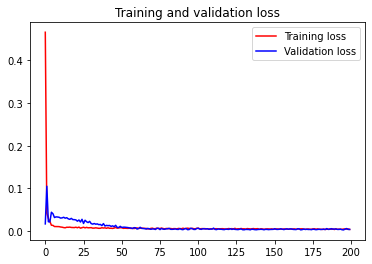

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [25]:
### Hagamos la predicción y verifiquemos las métricas de rendimiento
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

6/6 [==============================] - 0s 6ms/step


((270, 1), (175, 1))

## Evaluación del modelo

In [26]:
# Transformar de nuevo a la forma original

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Métricas de evaluación RMSE, MSE y MAE
Raiz del error cuadrático medio (RMSE), el error cuadrático medio (MSE) y el error absoluto medio (MAE) son una forma estándar de medir el error de un modelo en la predicción de datos cuantitativos.

In [27]:
# Métricas de evaluación RMSE y MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  3.2428559324726076
Train data MSE:  10.516114598772784
Train data MAE:  2.49130729708478
-------------------------------------------------------------------------------------
Test data RMSE:  6.138002302141009
Test data MSE:  37.67507226108833
Test data MAE:  4.911112183671874


### Puntuación de regresión de varianza explicada

La puntuación de varianza explicada explica la dispersión de errores de un conjunto de datos dado, y la fórmula se escribe de la siguiente manera: Aquí, y Var(y) es la varianza de los errores de predicción y los valores reales, respectivamente. Las puntuaciones cercanas a 1,0 son muy deseadas, lo que indica mejores cuadrados de las desviaciones estándar de los errores.

In [28]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("The test data explained the variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.896110081880195
The test data explained the variance regression score: 0.9420155233561655


### Puntuación R2 para regresión

R-cuadrado (R2) es una medida estadística que representa la proporción de la varianza de una variable dependiente que se explica por una variable o variables independientes en un modelo de regresión.

1 = mejor
0 o < 0 = peor

In [29]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8776145584141937
Test data R2 score: 0.8986869692120852


### Pérdida de regresión, Pérdida de regresión de desviación media gamma (MGD) y pérdida de regresión de desviación media de Poisson (MPD)

In [30]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.00039738876742396735
Test data MGD:  0.0028588003449376664
----------------------------------------------------------------------
Train data MPD:  0.06448557215517065
Test data MPD:  0.3257601143287991


## Comparación del precio de cierre de la acción original y el precio de cierre previsto

In [31]:
# predicciones de cambio de train para trazar

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# predicciones de prueba de cambio para trazar
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparación entre el precio de cierre original y el precio de cierre previsto',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (477, 1)
Test predicted data:  (477, 1)


## Predecir los próximos 30 días

In [32]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


### Trazado de los últimos 15 días del conjunto de datos y los próximos 30 días previstos

In [33]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [34]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Precio de cierre de los últimos 15 días','Precio de cierre previsto para los próximos 30 días'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compara los últimos 15 días con los próximos 30 días',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Trazar todo el precio de cierre de las acciones con el próximo período de predicción de 30 días

In [35]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()